Load penetration data based on SBA PPP loans and BLS 2-digit NAICS codes

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
from scipy.sparse import identity
from plotnine import *    # python lib to use ggplot

# list of 2-digit NAICS sectors to include in the analysis
NAIC2lst = ['23' # Construction
            , '44-45' # (retail)
            , '54' # Professional and technical services
            , '62' # (health & social, includes childcare)
            , '71' # Arts, entertainment, and recreation
            , '72'] #(accommodation & food)]

fpath = '/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/'

# read nloans, amount, nestablishments per county and NAIC2 sector
df = pd.read_excel(fpath + 'PPPpenetrationBLS_County_NAICS2US.xlsx', engine='openpyxl' # , dtype={'STATEFP10':'object','COUNTYFP10':'object'}
                           )
# keep selected NAICS only
pens = df[df['NAICS2'].isin(NAIC2lst)]

Descriptive: Total loans and amt per state

Metrics: penetration, loan amount per employee, (tentatively) loan amount / average salary
Apply metrics on current allocation, average for NAICS2
- Total loans and amt per 2-dig NAICS
- Penetration: difference between NAICS 71-72 and other NAICS
- Look at penetration of subsectors within 71 and 72

In [ ]:
#pens['State'].unique()
mbefore = pens.assign( TotLoanAmount = pens['NLoans']*pens['AvgLoanAmount'], TotJobsReported = 
                      pens['NLoans']*pens['AvgJobsReported'] ).groupby('NAICS2').agg(
                {'NEstabs':'sum','NLoans':'sum','TotLoanAmount':'sum','TotJobsReported':'sum'} )
mbefore = mbefore.assign( AvgLoanAmount = mbefore['TotLoanAmount'] / mbefore['NLoans']
                        , penetration = mbefore['NLoans'] / mbefore['NEstabs']
                        , LoanAmtperEmp = mbefore['TotLoanAmount'] / mbefore['TotJobsReported'] 
                        , actual = 1 )
mbefore

,NEstabs,NLoans,TotLoanAmount,TotJobsReported,AvgLoanAmount,penetration,LoanAmtperEmp,actual
NAICS2,,,,,,,,
23,805837,416888,6.318184e+10,4535464.0,151555.921331,0.517335,13930.624283,1
44-45,1035624,392583,3.823744e+10,4141177.0,97399.626913,0.379079,9233.470999,1
54,1116275,544934,6.410520e+10,4279029.0,117638.471477,0.488172,14981.249909,1
62,1699461,439644,6.522109e+10,6782591.0,148349.767123,0.258696,9615.954289,1
71,152154,102897,7.850222e+09,1210601.0,76292.042483,0.676269,6484.566174,1
72,733341,345285,4.136709e+10,6905667.0,119805.650009,0.470838,5990.311126,1


Apply metrics on current allocation, average for NAICS3

### Simulate allocation maximizing loan amt per job (will give loans to estabs with least jobs)
Formulation:  
Decision variables: $NLoans_{n,c}$  
where $n$: NAICS code in [23, 44-45, 54, 62, 71, 72]  
and $c$: county in US
\begin{equation*}
max_{NLoans_{n,c}}\ \sum_{n,c}LoanAmtperEmp_{n,c} = \sum_{n,c}\frac{TotLoanAmount_{n,c}}{TotJobsReported_{n,c}} \\
= \sum_{n,c}NLoans_{n,c}*\frac{L}{TotJobsReported_{n,c}}
\end{equation*}  
where $L = TotLoanAmount / TotNLoans$ (we assume that loan amount is the same for all loans and is the average of first round)  
Subject to  
$Nloans_{n,c} <= NEstabs_{n,c}$ for any sector n and county c  
$\sum_{n,c}NLoans_{n,c} = TotNLoans$ (preserve same number of loans from first round)  
$Nloans_{n,c} >= 0$

In [ ]:
Npairs = pens.shape[0]
TotNLoans = pens['NLoans'].sum()
tmp = pens.assign( TotLoanAmount = pens['AvgLoanAmount'] * pens['NLoans']
                 , TotJobsReported = pens['AvgJobsReported'] * pens['NLoans'] )
L = tmp['TotLoanAmount'].sum() / TotNLoans
# objective function coefficients
oc = L / tmp['TotJobsReported']
oc[oc.isna()] = 0
oc[np.isinf(oc)] = 0
# inequality constraint matrix and vector A @ x <= b
Au = identity( Npairs, dtype='int8' ) 
bu = pens['NEstabs']
# inequality constraint matrix
Ae = np.ones([1,Npairs])

In [ ]:
# Solver
res = linprog(oc, A_ub=Au, b_ub=bu, A_eq=Ae, b_eq=TotNLoans)

__main__:2: OptimizeWarning: Sparse constraint matrix detected; setting 'sparse':True.


In [ ]:
# check solution
print('Total loans from 1st round:', TotNLoans )
print('Total loans from linprog:', sum(res.x) )
nloansim = res.x.round()
print('Total loans, rounded:', sum(nloansim) )

Total loans from 1st round: 2242231
Total loans from linprog: 2242230.999991421
Total loans, rounded: 2242231.0


In [ ]:
penssim = pens[['State','COUNTYfips','NAICS2','NEstabs','AvgJobsReported']
              ].assign( NLoans = nloansim )
msim = penssim.assign( TotLoanAmount = penssim['NLoans']*L, TotJobsReported = 
                      penssim['NLoans']*penssim['AvgJobsReported'] ).groupby('NAICS2').agg(
                {'NEstabs':'sum','NLoans':'sum','TotLoanAmount':'sum','TotJobsReported':'sum'} )
msim = msim.assign( AvgLoanAmount = msim['TotLoanAmount'] / msim['NLoans']
                        , penetration = msim['NLoans'] / msim['NEstabs']
                        , LoanAmtperEmp = msim['TotLoanAmount'] / msim['TotJobsReported']
                        , actual = 0 )
msim

,NEstabs,NLoans,TotLoanAmount,TotJobsReported,AvgLoanAmount,penetration,LoanAmtperEmp,actual
NAICS2,,,,,,,,
23,805837,218976.0,2.734114e+10,2.814214e+06,124859.074134,0.271737,9715.373263,0
44-45,1035624,261710.0,3.267687e+10,2.632892e+06,124859.074134,0.252708,12411.019253,0
54,1116275,522450.0,6.523262e+10,4.478779e+06,124859.074134,0.468030,14564.823242,0
62,1699461,905906.0,1.131106e+11,1.239077e+07,124859.074134,0.533055,9128.614402,0
71,152154,24219.0,3.023962e+09,1.916425e+05,124859.074134,0.159174,15779.183804,0
72,733341,308970.0,3.857771e+10,6.689386e+06,124859.074134,0.421318,5767.003248,0


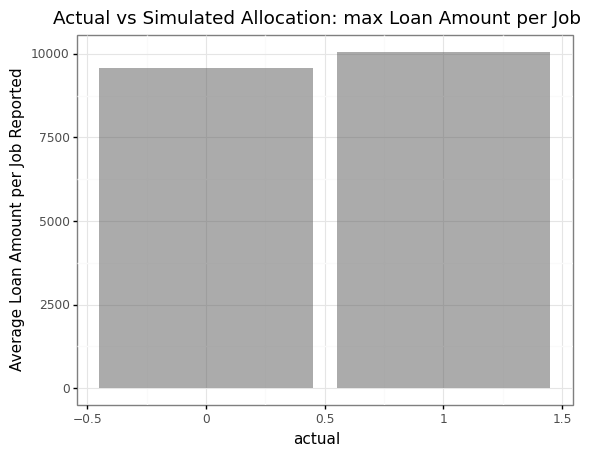

<ggplot: (8788044053013)>

In [ ]:
# join current and simulated allocations
comp = pd.concat([mbefore, msim]).reset_index()
# Total amount per job of current and simulated allocations
compsum = comp.groupby('actual').agg('sum')
compsum = compsum.assign(AvgLoanAmount = compsum['TotLoanAmount'] / compsum['NLoans']
                         , penetration = compsum['NLoans'] / compsum['NEstabs']
                         , LoanAmtperEmp = compsum['TotLoanAmount'] / compsum['TotJobsReported'] 
                        ).reset_index()

ggplot( compsum, aes(x='actual', y='LoanAmtperEmp')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
#          ) + scale_alpha_manual(values=[.1, .3]
          ) + theme_bw(
          ) + ylab('Average Loan Amount per Job Reported'
          ) + ggtitle('Actual vs Simulated Allocation: max Loan Amount per Job'
          ) #+ scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          #) + coord_flip()

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


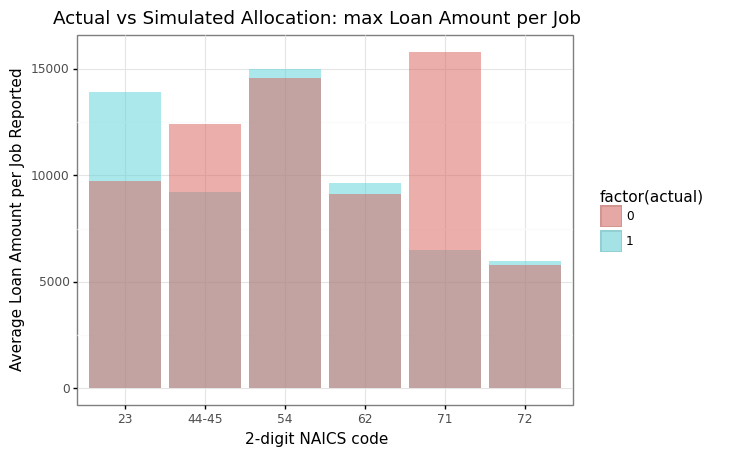

<ggplot: (8788043614437)>

In [ ]:
# plot current and simulated allocations per NAICS
ggplot( comp, aes(x='NAICS2', y='LoanAmtperEmp',fill='factor(actual)')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
#          ) + scale_alpha_manual(values=[.1, .3]
          ) + theme_bw(
          ) + xlab('2-digit NAICS code'
          ) + ylab('Average Loan Amount per Job Reported'
          ) + ggtitle('Actual vs Simulated Allocation: max Loan Amount per Job'
          ) #+ scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          #) + coord_flip()


In [ ]:
tmp = pens['']
# optmize allocation to maximize penetration
#max Sum[all county-naics pairs](Nloansi / NEstabsi)
#	s.t. Sum[all county-naics pairs](Nloansi) = Ntotal
#		Nloansi <= NEstabsi
#		Nloansi >= 0

# Constraints
n = pens.shape[0] # number of decision variables: county-NAICS pairs
NEstabsTot = pens['NEstabs'].sumn()
# Sum[all county-naics pairs](Nloansi) = NEstabsTot
A_eq = np.ones( (1,n) ) 
b_eq = [NEstabsTot]
# Nloansi <= NEstabsi
A_ub = np.identity( n )
b_ub = pens['NEstabs'].to_numpy()

# vector of coefficients of objective function: 1/NEstabsi
c = 1 / b_ub
c = ( 1 / pens['NEstabs'] ).array